## Intro:
The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.

They have chosen a random sample of users and emailed them. The email lets the user know about a new feature implemented on the site. From the marketing team perspective, <font color = red>success is if the user clicks on the link inside of the email</font>. This link takes the user to the company site.

You are in charge of figuring out how the email campaign performed and were asked the following questions:

## Tasks:
- What percentage of users opened the email and what percentage clicked on the link within the email?

- The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?

- By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

- Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

## Data:
### email_table - info about each email that was sent

Columns:

- email_id : the Id of the email that was sent. It is unique by email.
- email_text : there are two versions of the email: one has “long text” (i.e. has 4 paragraphs) and one has “short text” (just two paragraphs)
- email_version : some emails were “personalized” (i.e. they had the name of the user receiving the email in the incipit, such as “Hi John”), while some emails were “generic” (the incipit was just “Hi,”).
- hour : the local time on which the email was sent.
- weekday : the day on which the email was sent.
- user_country : the country where the user receiving the email was based. It comes from the user ip address when she created the account.
- user_past_purchases : how many items in the past were bought by the user receiving the email

### email_opened_table - the id of the emails that were opened at least once.

Columns:

- email_id : the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it.


### link_clicked_table - the id of the emails whose link inside was clicked at least once.

Columns:

- email_id : if the user clicked on the link within the email, then the id of the email shows up on this table.

Task 1:
- What percentage of users opened the email and what percentage clicked on the link within the email?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#loading all three tables

email = pd.read_csv('email/email_table.csv')
opened = pd.read_csv('email/email_opened_table.csv')
clicked = pd.read_csv('email/link_clicked_table.csv')

In [2]:
print(email.head())
print(opened.head())
print(clicked.head())

   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  
4                    6  
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561


In [7]:
opened.head()

,email_id,opened
0,284534,1
1,609056,1
2,220820,1
3,905936,1
4,164034,1


In [8]:
#label emails with 'clicked' and 'opened'

opened['opened'] = 1
clicked['clicked'] = 1

data = pd.merge(left = email, right = opened, how = 'left', on = 'email_id')
data = pd.merge(left = data, right = clicked, how = 'left', on = 'email_id')

data.head(15)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN
5,684440,long_email,personalized,6,Sunday,UK,3,NaN,NaN
6,139620,short_email,personalized,9,Saturday,US,8,1.0,NaN
7,694933,long_email,generic,8,Saturday,US,2,NaN,NaN
8,485760,long_email,personalized,5,Monday,US,4,NaN,NaN
9,592665,short_email,personalized,23,Wednesday,US,3,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 10345 non-null float64
clicked                2119 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.6+ MB


In [11]:
#quick check on merge by comparing opend and clicked columns
print(data['opened'].sum())
print(data['clicked'].sum())

10345.0
2119.0


In [15]:
print('user percentage who opened email:', (data['opened'].sum()/data.shape[0])*100, '%')
print('user percentage who cliked on the link:', (data['clicked'].sum()/data.shape[0])*100, '%')

user percentage who opened email: 10.345 %
user percentage who cliked on the link: 2.119 %


### Task2:
- The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?


In [19]:
#replace all null values in 'opened' and 'clicked' with 0 and cast the type  to integer
data['clicked'].fillna(0, inplace = True)
data['clicked'] = data['clicked'].astype(int)

data['opened'].fillna(0, inplace = True)
data['opened'] = data['opened'].astype(int)
data.head(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0
5,684440,long_email,personalized,6,Sunday,UK,3,0,0
6,139620,short_email,personalized,9,Saturday,US,8,1,0
7,694933,long_email,generic,8,Saturday,US,2,0,0
8,485760,long_email,personalized,5,Monday,US,4,0,0
9,592665,short_email,personalized,23,Wednesday,US,3,0,0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null int64
clicked                100000 non-null int64
dtypes: int64(5), object(4)
memory usage: 7.6+ MB


In [38]:
#build random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#random seed set
np.random.seed(4684)

#drop variables that are not actionable
df_mdl = data.drop(columns= ['email_id', 'opened'])
  
#make dummy variables
data_dummy = pd.get_dummies(df_mdl)

#random data split, 7/3
train, test = train_test_split(data_dummy, test_size = 0.3)

#modeling 
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop('clicked', axis = 1), train['clicked'])

#see out of bag score and confusion matrix
print('oob score: ', rf.oob_score_)
print(pd.DataFrame(confusion_matrix(train['clicked'], rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

oob score:  0.9489285714285715
       0     1
0  66327  2166
1   1409    98


In [39]:
#check the model performance on the unseen test dataset
print(rf.score(test.drop('clicked', axis=1), test['clicked']))
print(pd.DataFrame(confusion_matrix(test['clicked'], rf.predict(test.drop('clicked', axis = 1)), labels = [0,1])))

0.9532
       0    1
0  28561  827
1    577   35


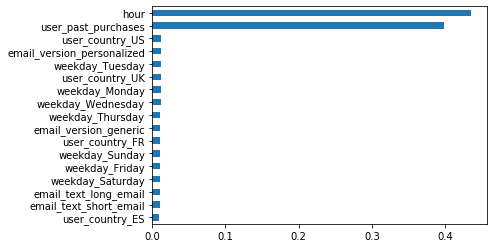

In [40]:
#check on feature importance
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('clicked', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

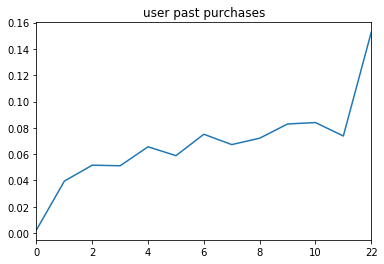

In [43]:
# pip install -q pdpbox

from pdpbox import pdp, info_plots
  
#user_past_purchases
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)), 
                          feature='user_past_purchases', 
                          num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='line', title='user past purchases')
plt.show()

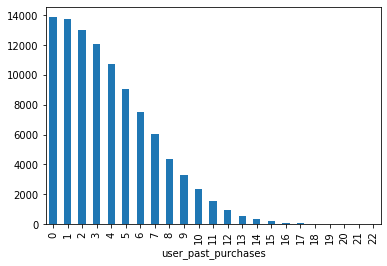

In [51]:
data.groupby('user_past_purchases').size().plot.bar()

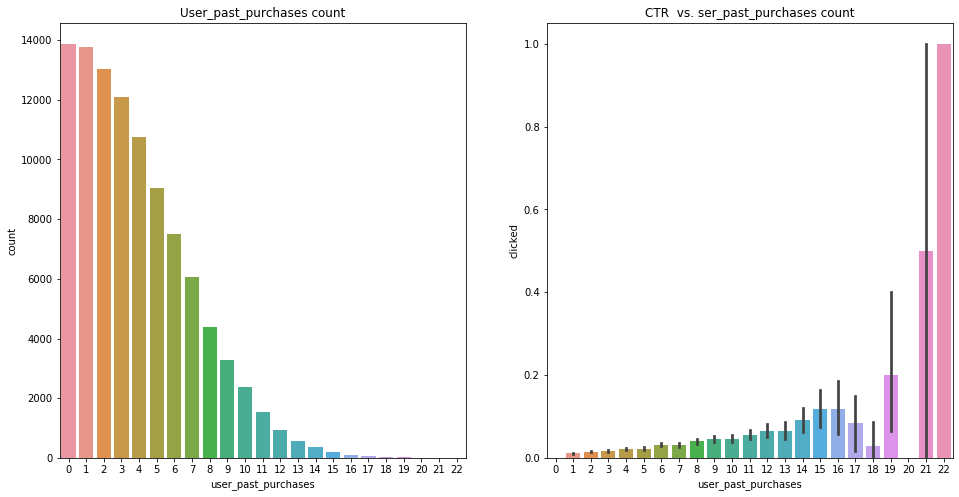

In [52]:
fir,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (16,8))
sns.countplot(x= 'user_past_purchases', data = data, ax = ax[0])
ax[0].set_title('User_past_purchases count')

sns.barplot(x = 'user_past_purchases', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title("CTR  vs. ser_past_purchases count")
plt.show()

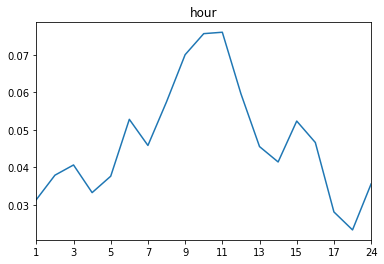

In [53]:
#hour
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)), 
                          feature='hour', 
                          num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='line', title='hour')
plt.show()

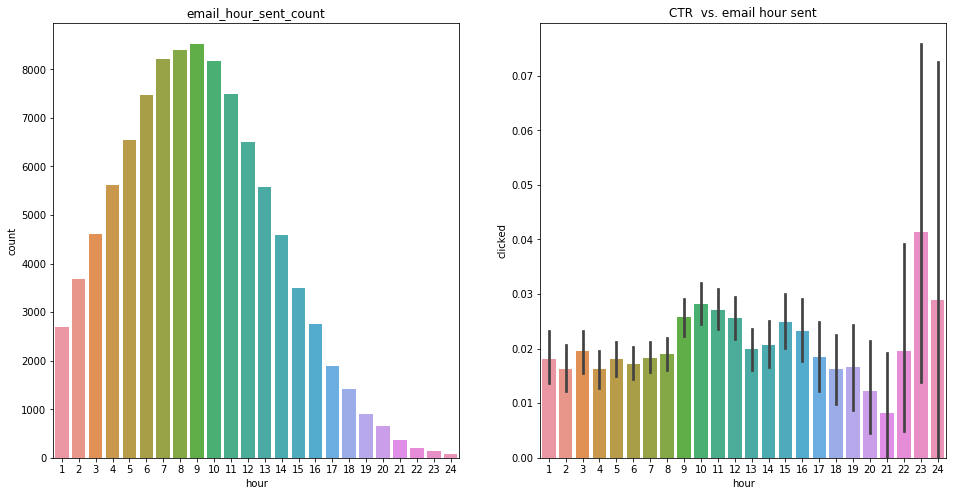

In [54]:
#hour 
fir,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (16,8))
sns.countplot(x= 'hour', data = data, ax = ax[0])
ax[0].set_title('email_hour_sent_count')

sns.barplot(x = 'hour', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title("CTR  vs. email hour sent")
plt.show()

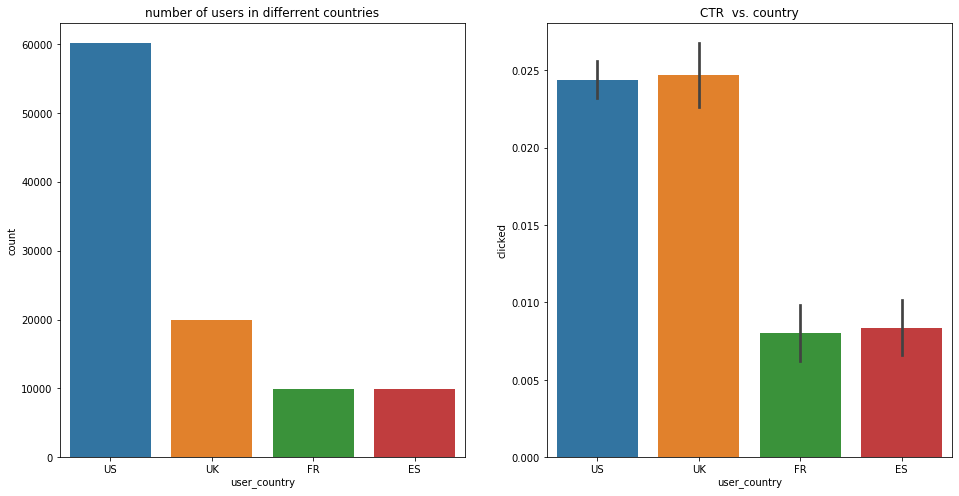

In [56]:
#country
fir,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (16,8))
sns.countplot(x= 'user_country', data = data, ax = ax[0])
ax[0].set_title('number of users in differrent countries')

sns.barplot(x = 'user_country', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title("CTR  vs. country")
plt.show()

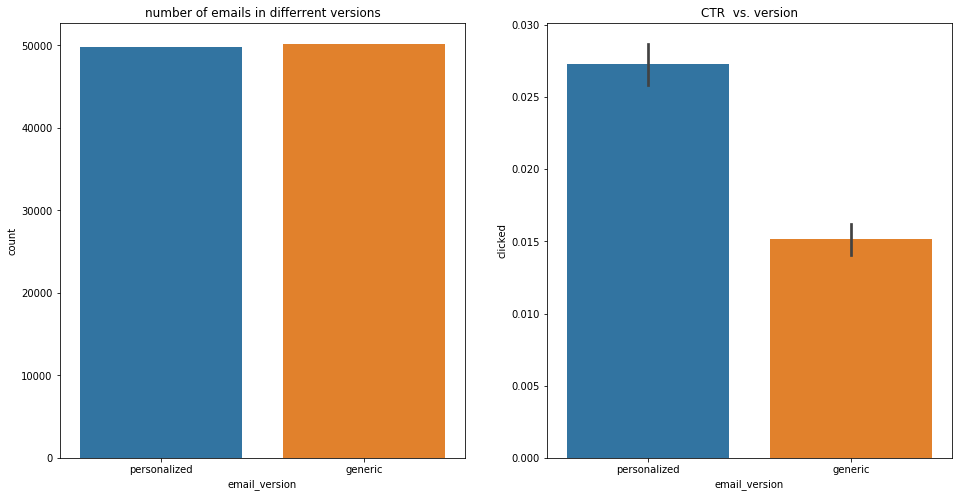

In [57]:
#email version
fir,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (16,8))
sns.countplot(x= 'email_version', data = data, ax = ax[0])
ax[0].set_title('number of emails in differrent versions')

sns.barplot(x = 'email_version', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title("CTR  vs. version")
plt.show()

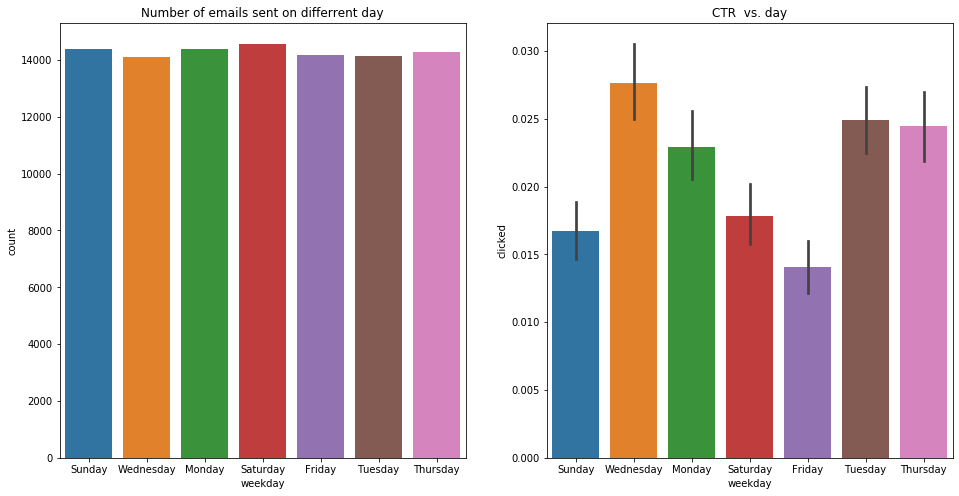

In [58]:
#weekday
fir,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (16,8))
sns.countplot(x= 'weekday', data = data, ax = ax[0])
ax[0].set_title('Number of emails sent on differrent day')

sns.barplot(x = 'weekday', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title("CTR  vs. day")
plt.show()

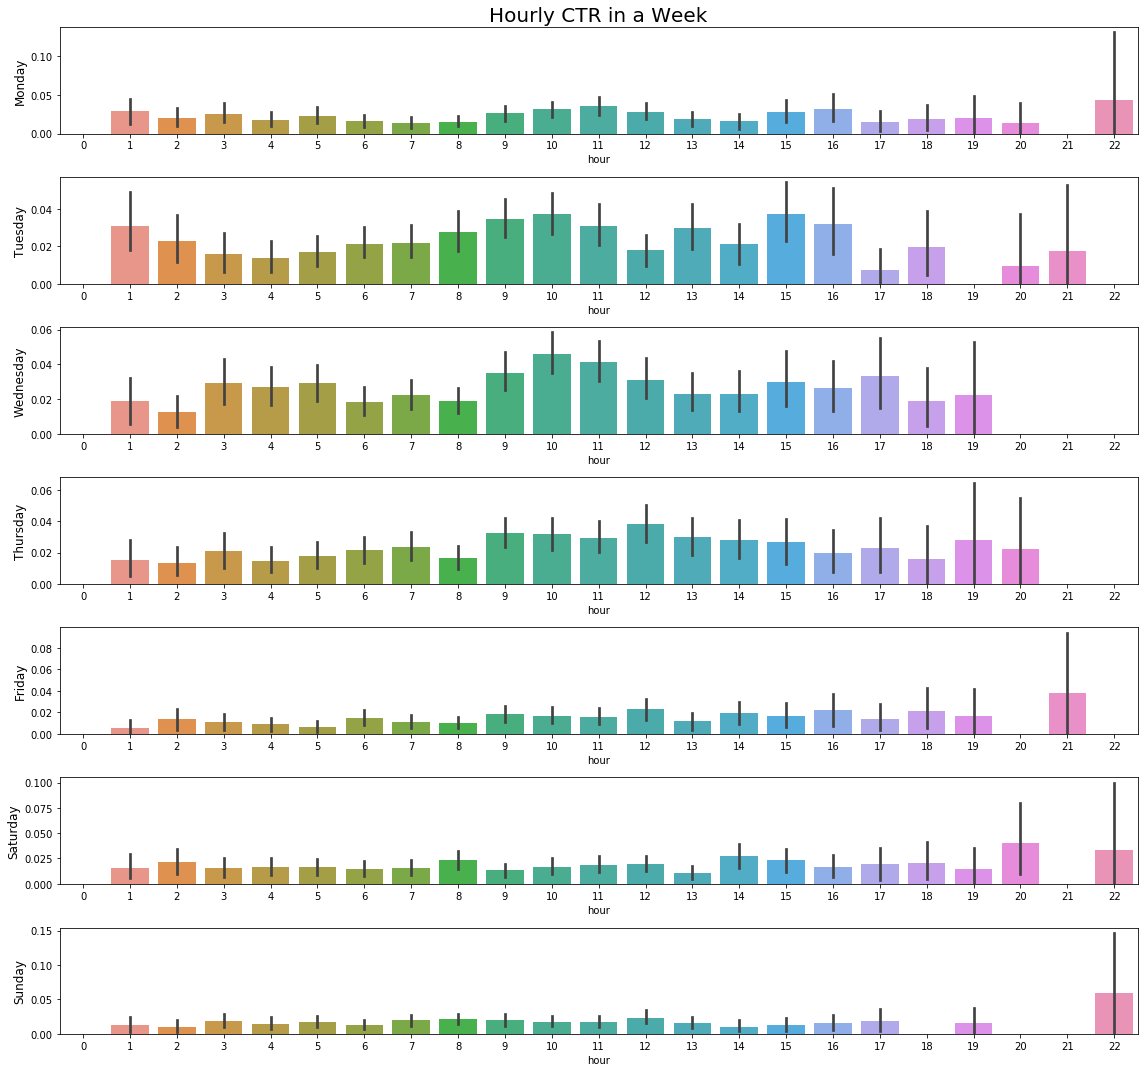

In [63]:
#CTR in different day
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(16, 15))
i = 0
for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    sns.barplot(x='hour', y = 'clicked', data=data[data['weekday'] == day], ax=ax[i], order=order)
    ax[i].set_ylabel(day, fontsize=12)
    ax[0].set_title('Hourly CTR in a Week', fontsize=20)
    i += 1
plt.tight_layout()
plt.show()

# Analysis

## Insights:

#### Metrics result:
- user percentage who opened email: 10.345 %
- user percentage who cliked on the link: 2.119 %

#### User characteristics: 
- English countries have much higher CTR compared to others (2.4% to 0.7%)
- People with higher past purchases tend to have a higher CTR (not that strong, less users have high past purchases)

#### Emial characteristics:
- Personalized emails have 2.7% CTR whitle the generic counterpart has only 1.5%
- Emails sent from 9am - 4pm during workdays (Tuesday - Thursday) have significantly higer CTR, the Sunday emails have very low CTR.




## Suggestions:

- Marketing team should have language-specific emails 
- Initiate a loyalty program to increase customer retention (higher purchases people should have more personalized recommendation)
- Emails should always be perosnalzied if it's possible
- Marketing team should focus on sending emails more during workdays
